<a href="https://colab.research.google.com/github/mcrn2000/MINE_4206_Analisis_con_Machine_Learning/blob/main/MINE_4201_Laboratorio_3_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# solo ejecutar si esta en colab y necesita instalar librerias
!pip install surprise
!pip install sns

     |████████████████████████████████| 11.8MB 6.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617543 sha256=9336bd092f270676dd590b6b9ff8a2a7b244fbb2a296c74fcd21c31c9d7b9dc8
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
  Created wheel for sns: filename=sns-0.1-cp37-none-any.whl size=2664 sha256=48dc00c8613e5e21c1f1931379b713df4b7f0877a2222dfbcf5a30c47ed27b0e
  Stored in directory: /root/.cache/pip/wheels/be/a5/d8/4390400ed430c8186a6af96dbb1cc7d0a00a5dee15d268b627
Successfully built sns


In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

%matplotlib inline

# MINE 4201- Laboratorio 3 - SR por factorización

En este laboratorio se ajustará un modelo de factorización utilizando el framework Surprise:
https://surprise.readthedocs.io/en/stable/index.html

Los datos fueron previamente separados en conjunto de entrenamiento, validación y test.

## 1. Exploración de los datasets de entrenamiento, validación y prueba

Ejecute las siguientes líneas y concluya sobre cómo están construidos estos datasets

In [28]:
pwd

'/content'

In [29]:
#Cambie el path de los datos dependiendo de donde estan (máquina local o google colab)

In [30]:
path='/content/'

In [31]:
train_df = pd.read_csv( path+'train', sep = '::', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ], engine = 'python' )
validation_df = pd.read_csv( path+'validation', sep = '::', names = [ 'user_id', 'item_id', 'rating', 'timestamp'], engine = 'python' )
test_df = pd.read_csv( path+'test', sep = '::', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ], engine = 'python' )
movies_df=pd.read_csv(path+'movies.csv')

In [32]:
train_df.head( 5 )


user_id  item_id  rating  timestamp
0      181      930       1  878963275
1       13       72       4  882141727
2       13      181       5  882140354
3      181      619       3  878963086
4      181      334       1  878961749

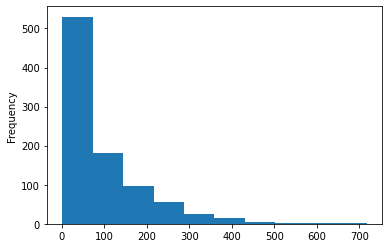

In [33]:
train_df['user_id'].value_counts().plot.hist()

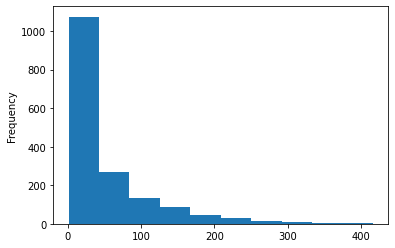

In [34]:
train_df['item_id'].value_counts().plot.hist()

In [35]:
movies_df.head()

movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]

In [36]:
conteo_peliculas=train_df['item_id'].value_counts().to_frame()

In [37]:
conteo_peliculas.columns=['conteo']


In [38]:
conteo_peliculas=conteo_peliculas.merge(movies_df, how='left', right_on='movieId', left_index=True)

In [39]:
conteo_peliculas.head(20)

conteo  ...                                       genres
49.0      416  ...                       Crime|Mystery|Thriller
179.0     386  ...                              Action|Children
98.0      372  ...                               Drama|Thriller
0.0       345  ...  Adventure|Animation|Children|Comedy|Fantasy
172.0     343  ...                                       Comedy
119.0     336  ...                                        Drama
96.0      315  ...                              Action|Thriller
290.0     315  ...                               Comedy|Romance
255.0     312  ...    Adventure|Children|Comedy|Fantasy|Romance
55.0      312  ...            Adventure|Children|Comedy|Fantasy
125.0     312  ...                                        Drama
283.0     301  ...                       Action|Sci-Fi|Thriller
6.0       293  ...                               Comedy|Romance
170.0     291  ...                       Action|Sci-Fi|Thriller
285.0     289  ...                        Action|Crime|Thriller
78.0      286  ...                               Drama|Thriller
234.0     285  ...                               Comedy|Romance
202.0     283  ...                                       Action
115.0     282  ...                                  Crime|Drama
166.0     278  ...                         Action|Drama|Romance

[20 rows x 4 columns]

In [48]:
validation_df.head( 5 )


user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

In [49]:
test_df.head( 5 )


user_id  item_id  rating  timestamp
0       13      498       4  882139901
1       13      892       3  882774224
2       13      229       4  882397650
3      181      741       1  878962918
4      181     1015       1  878963121

In [45]:
train_df[['rating','timestamp']].describe()

rating     timestamp
count  81140.000000  8.114000e+04
mean       3.516207  8.834829e+08
std        1.126096  5.340285e+06
min        1.000000  8.747247e+08
25%        3.000000  8.794481e+08
50%        4.000000  8.826785e+08
75%        4.000000  8.881927e+08
max        5.000000  8.932866e+08

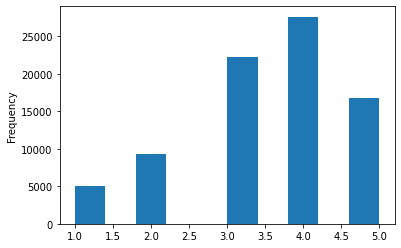

In [46]:
train_df.rating.plot.hist()

In [47]:
validation_df[['rating','timestamp']].describe()

rating     timestamp
count  9430.000000  9.430000e+03
mean      3.587805  8.837354e+08
std       1.120240  5.360562e+06
min       1.000000  8.747247e+08
25%       3.000000  8.794515e+08
50%       4.000000  8.833904e+08
75%       4.000000  8.886378e+08
max       5.000000  8.932866e+08

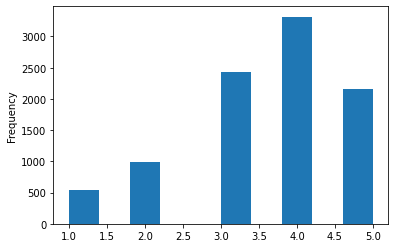

In [50]:
validation_df.rating.plot.hist()

In [51]:
test_df[['rating','timestamp']].describe()

rating     timestamp
count  9430.000000  9.430000e+03
mean      3.589396  8.837179e+08
std       1.123800  5.349370e+06
min       1.000000  8.747249e+08
25%       3.000000  8.794518e+08
50%       4.000000  8.833653e+08
75%       4.000000  8.886326e+08
max       5.000000  8.932866e+08

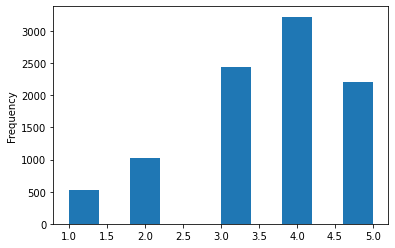

In [52]:
test_df.rating.plot.hist()

In [53]:
print( 'Train size: ' + str( train_df.shape ) )
print('Validation size: ' + str( validation_df.shape ) )
print( 'Test size: ' + str( test_df.shape ) )

Train size: (81140, 4)
Validation size: (9430, 4)
Test size: (9430, 4)


In [54]:
# En movies queda la información sobre las películas y su id
movies_df.head()

movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]

## 2. Transformación de los dataset al formato de Surprise

El framework lee los dataframes de pandas y los transforma a un formato que es aceptado por él

In [66]:
# Se establece el rango en el cual se aceptaran los ratings
reader = Reader( rating_scale = ( 1, 5 ) )

In [67]:
# Transformación de los datasets, puede leer los datasets directamente desde el disco sin necesidad de pasar por pandas
train_data = Dataset.load_from_df( train_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )
validation_data = Dataset.load_from_df( validation_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )
test_data = Dataset.load_from_df( test_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )

In [68]:
# Surprise requiere que explicitamente los datasets sean transformados a datasets de entrenamiento y prueba en cada caso 
# Si bien no se entrenará sobre los datasets de validación y prueba, surprise requiere que sean tranformados a entrenamiento para posteriormente ser transformados a prueba
train_data = train_data.build_full_trainset()
validation_data = validation_data.build_full_trainset()
test_data = test_data.build_full_trainset()

In [69]:
# Finalmente, se convierten los 3 datasets a prueba ya que se medirá el error obtenido en los 3
train_data_2 = train_data.build_testset()
validation_data = validation_data.build_testset()
test_data = test_data.build_testset()

Cada película queda representada en el conjunto train con un id interno para los modelos de factorización, revise la documentación sobre ids internos y externos [aqui](https://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note)

In [70]:
movies_df.loc[movies_df.movieId==1]

movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy

In [73]:
#Revisar el id interno de la película con id 1 en el dataset
train_data.to_inner_iid(1)

16

## 3. Entrenamiento de un modelo SVD con bias

El modelo toma como base el promedio global. En este caso es de 3.5162

In [74]:
mean = train_data.global_mean
print( mean )

3.516206556568893


La clase SVD recibe los siguientes parámetros:
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
* n_factors: Número k de factores para realizar la recomendación
* n_epochs: Número de iteraciones a realizar sobre los datos
* biased: Si el modelo contempla los bias o solo la factorización
* lr_all: Tasa de aprendizaje del método
* reg_all: Parámetro de regularización
* init_mean y init_std_dev son los parámetros de la distribución usada para inicializar aleatoriamente los factores

Se prueba un modelo con bias sin regularización para k=5




In [75]:
algo = SVD( n_factors = 5, n_epochs = 200, biased = True, lr_all = 0.001, reg_all = 0, init_mean = 0, init_std_dev = 0.01, verbose = True )

In [76]:
# Se realiza el entrenamiento a partir del dataset debido
algo.fit( train_data )

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

Al finalizar el entrenamiento, se visualiza cómo quedo la matriz que representa a los usuarios ($p_u$) y la matriz que representa a los items ($q_i$)

In [77]:
pu = algo.pu

In [78]:
pu.shape

(911, 5)

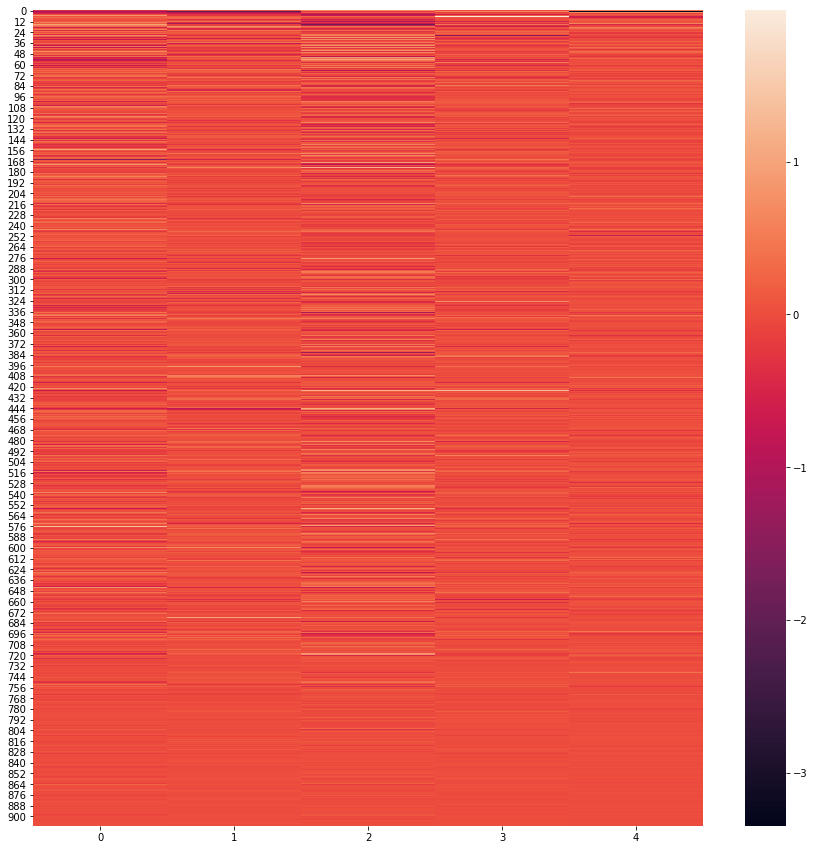

In [79]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( pu, ax = ax )

In [82]:
qi = algo.qi

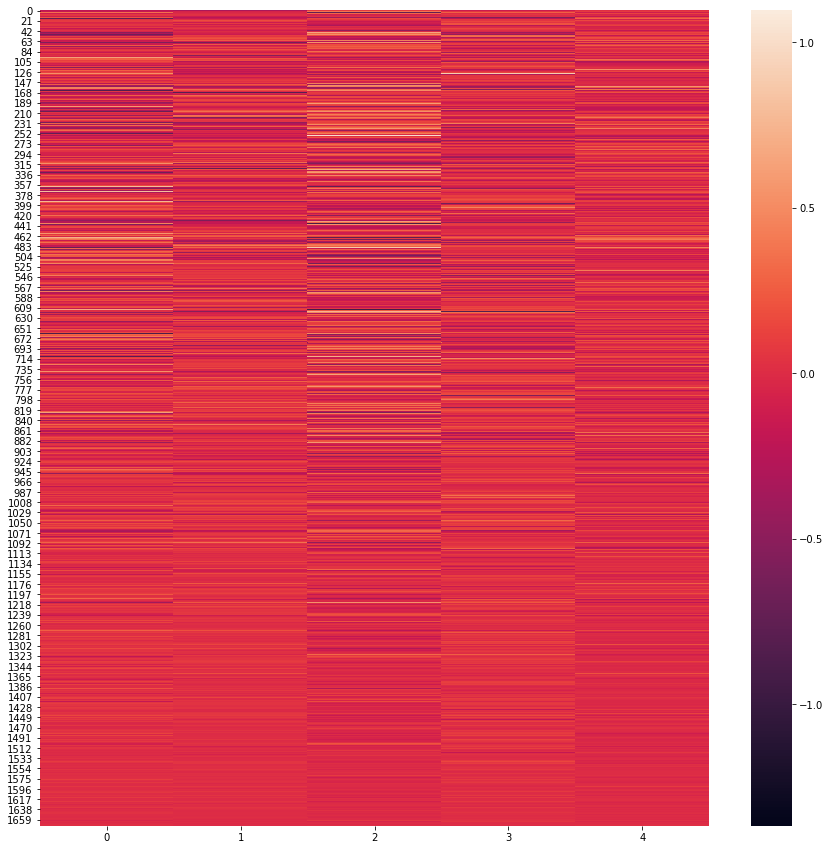

In [83]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( qi , ax = ax)

También se pueden visualizar los bias de usuarios e items $b_u$ y $b_i$

In [84]:
bi = algo.bi.reshape( algo.bi.shape[ 0 ], 1 )
bu = algo.bu.reshape( algo.bu.shape[ 0 ], 1 )

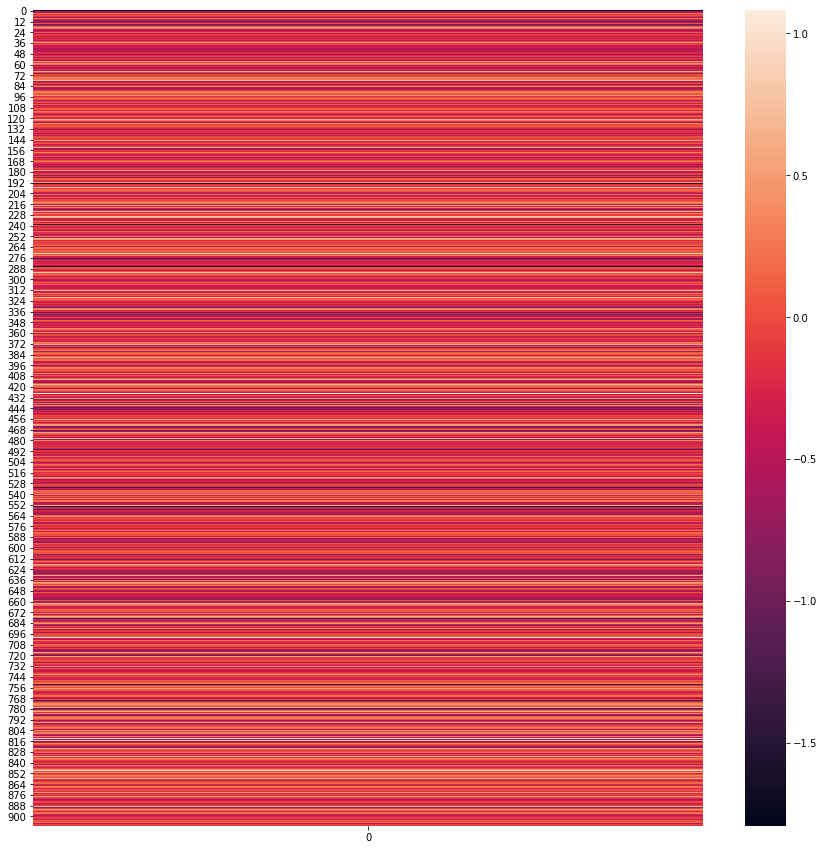

In [85]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( bu ,ax = ax)

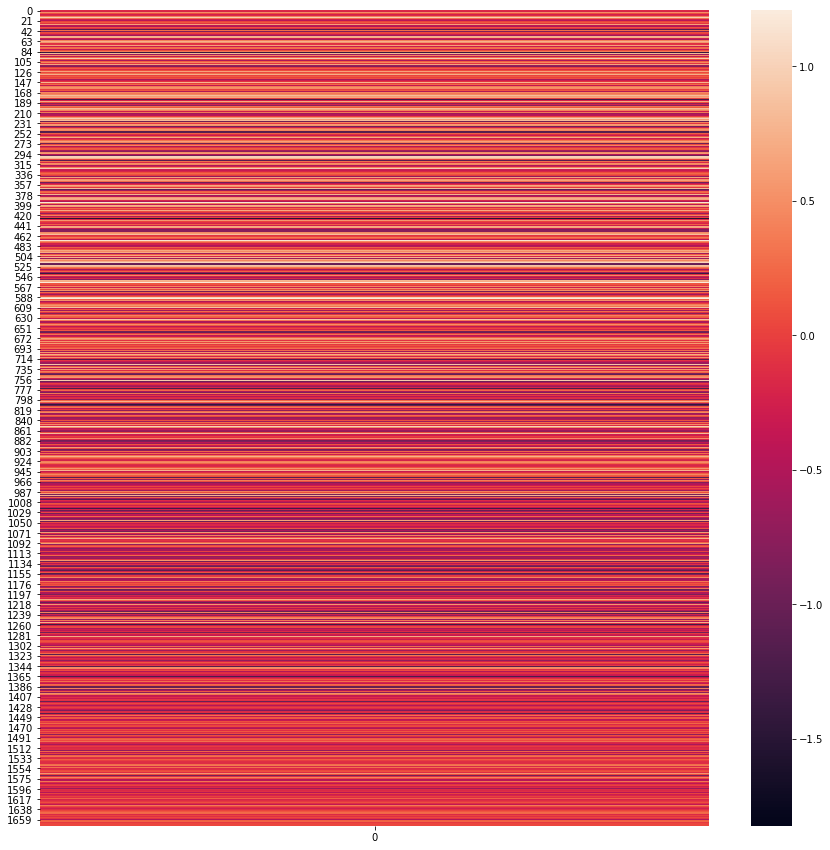

In [86]:
fig, ax =  plt.subplots(figsize=(15,15)) 

sns.heatmap( bi, ax = ax )

In [87]:
bi.shape

(1672, 1)

In [88]:
# Ejemplo bias de película con id 1
bi[train_data.to_inner_iid(1)]

array([0.50185973])

In [89]:
#Película con el máximo bias

In [90]:
np.amax(bi)

1.207481475804939

In [91]:
np.where(bi==np.amax(bi))

(array([591]), array([0]))

In [92]:
bi[1534]

array([1.15289875])

In [93]:
train_data.to_raw_iid(1534)

1449

In [94]:
conteo_peliculas[conteo_peliculas.movieId==train_data.to_raw_iid(1534)]

conteo  movieId                       title  genres
1409.0       7     1449  Waiting for Guffman (1996)  Comedy

In [95]:
train_df[train_df.item_id==train_data.to_raw_iid(1534)]

user_id  item_id  rating  timestamp
32518      561     1449       5  885808620
33292      409     1449       5  881107817
39592      585     1449       5  891283338
50049      385     1449       4  881047049
56498      934     1449       5  891191976
63269      234     1449       4  892333573
75662      932     1449       5  891248937

### Reconstrucción de la matriz original

Una vez se realiza la factorización, se puede reconstruir la predicción para cada una de las coordenadas de la matriz original

$\hat{r}_{ui}= \mu + b_{i} + b_{u} + p_{u}\dot q_{i}^{T} $

In [96]:
reconstruct = ( pu ).dot( ( qi ).T ) + bu + bi.T + mean

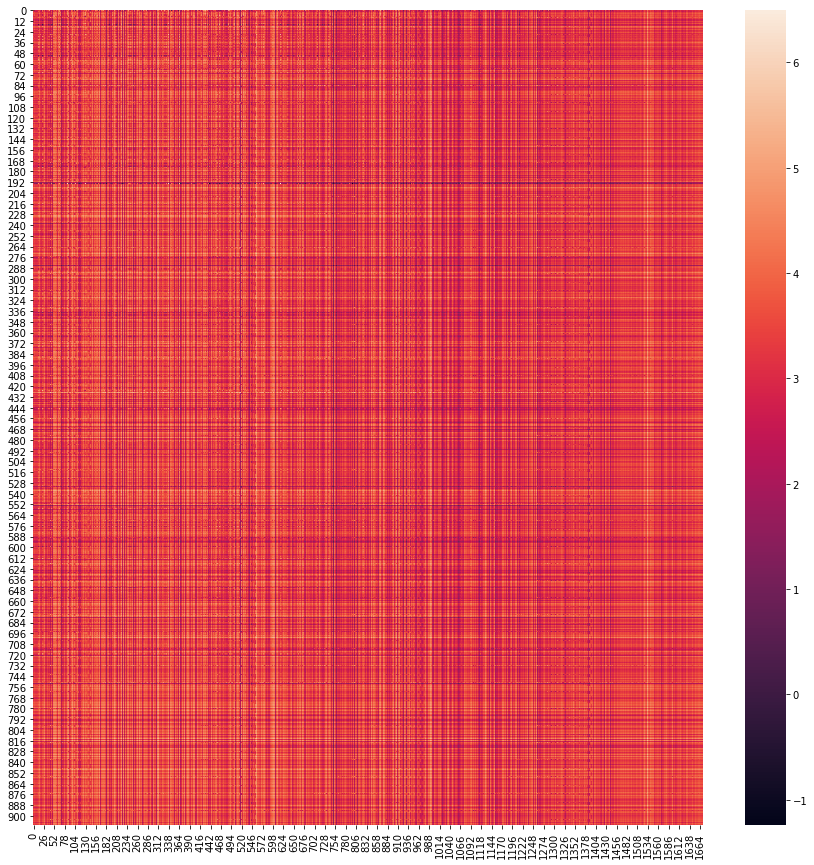

In [97]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( reconstruct, ax = ax )

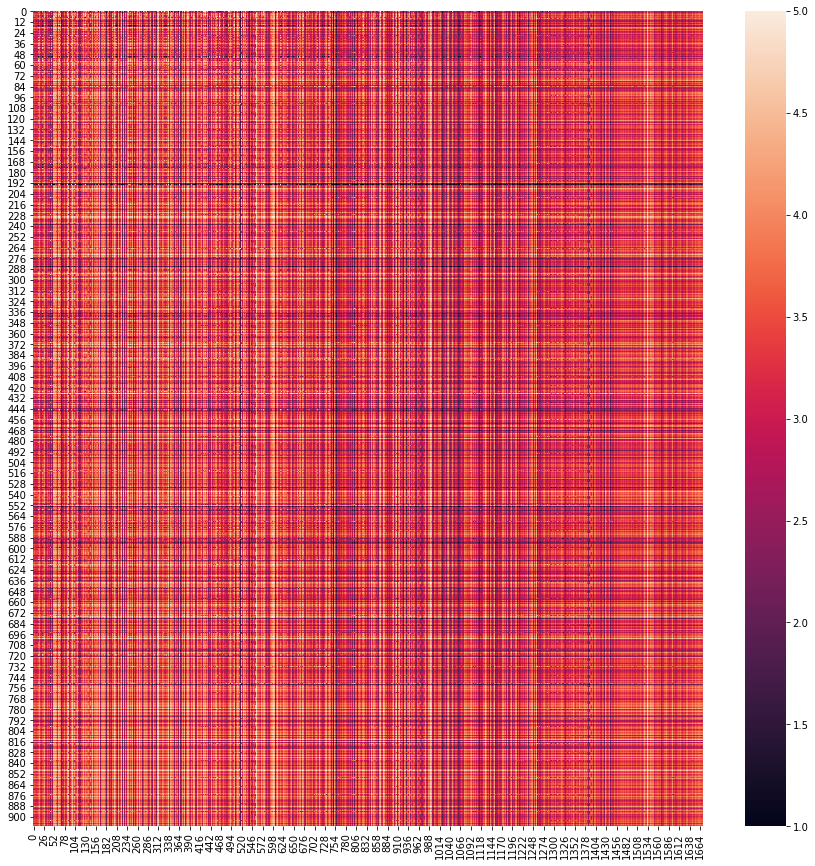

In [98]:
# Ya que algunos ratings reconstruidos están fuera del rango aceptado, se realiza un ajuste entre 1 y 5
reconstruct = np.clip( reconstruct, 1, 5 )
fig, ax =  plt.subplots(figsize=(15,15)) 

sns.heatmap( reconstruct , ax = ax)

Compare los resultados con la matriz original:

In [99]:
original = np.zeros( ( train_data.n_users , train_data.n_items ) )
for ( u, i, r ) in train_data.all_ratings():
    original[ u ][ i ] = r

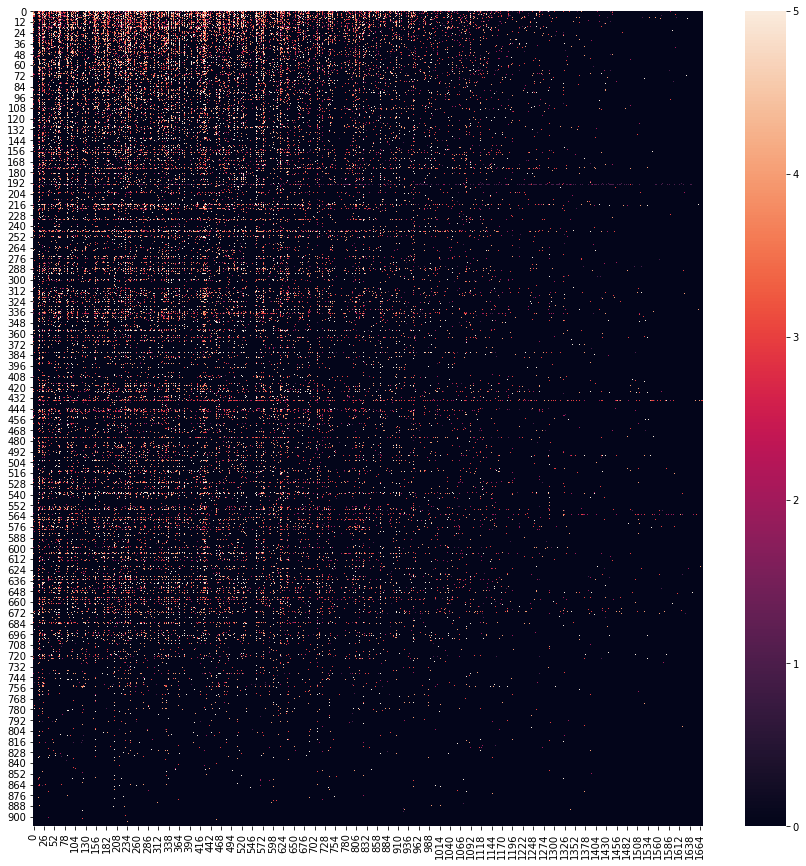

In [100]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( original, ax = ax )

### Se compara visualmente el error en las entradas conocidas de la matriz ( error en conjunto de entrenamiento )

In [101]:
known_entries = original == 0

In [102]:
reconstruct[ known_entries ] = 0

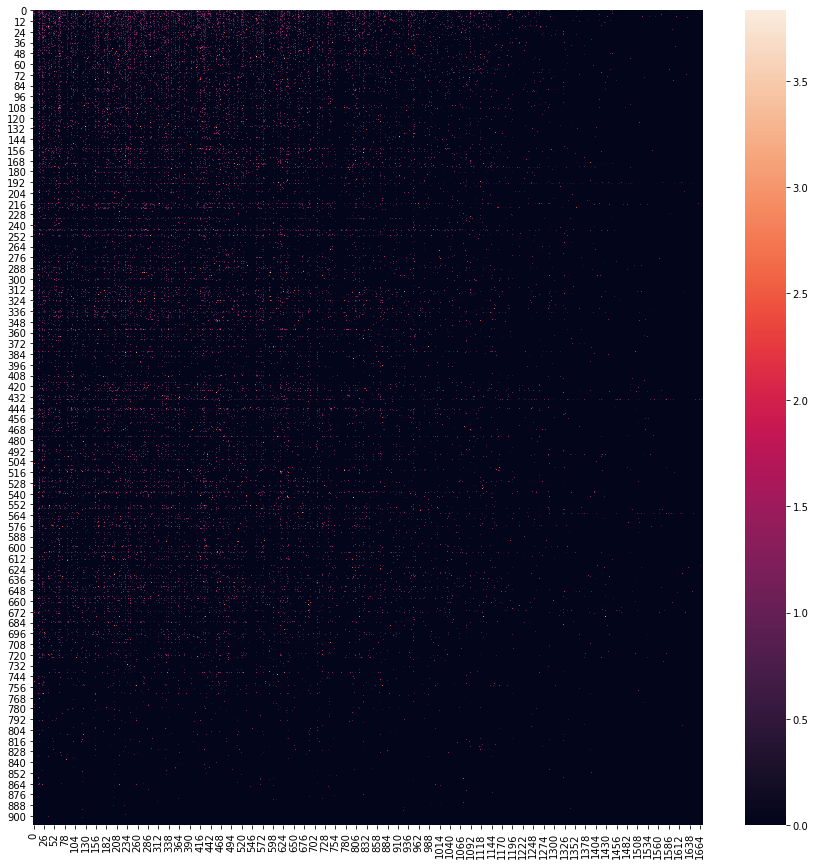

In [103]:
fig, ax =  plt.subplots(figsize=(15,15)) 

sns.heatmap( np.abs( original - reconstruct ) , ax = ax)

## 3. Evaluación de predicciones

A partir del modelo entrenado, se mide el error del modelo en el conjunto de entrenamiento, validación y prueba

In [104]:
predictions_train = algo.test( train_data_2 )

In [105]:
predictions_validation = algo.test( validation_data )
predictions_test = algo.test( test_data )

In [106]:
accuracy.rmse( predictions_train, verbose = True )

RMSE: 0.8380


0.8379731548662287

In [107]:
accuracy.rmse( predictions_validation, verbose = True )

RMSE: 0.9592


0.9591874381323633

In [108]:
accuracy.rmse( predictions_test, verbose = True )

RMSE: 0.9737


0.9737490239926706

## 4. Selección de hiper-parámetros

Utilice este notebook para realizar los siguientes ajustes:

4.1 Aumente el número k de dimensiones del vector y documente los resultados. Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores (cree una gráfica donde muestre el efecto que tiene k sobre los errores)

4.2 Para un k fijo, aumente la regularización para diferentes valores [0.001,0.01,0.1,1,10].  Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores, por ejemplo, comparando los tamaños de los parámetros.

4.3 ¿Según los resultados obtenidos, qué otros hiperparámetros cambiaría y en qué dirección para mejorar el performance del modelo?